# EmotionsByFace

This notebook loads the FER2013 dataset, performs exploratory analysis, fine-tunes a pretrained CNN (ResNet18), 
and evaluates the model using a confusion matrix and relevant metrics.

**Team 3 – Emotion Recognition Project**


In [9]:
# Install dependencies (run once per environment)
!pip install -q torch torchvision pandas scikit-learn matplotlib seaborn kaggle tqdm pillow


In [10]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm

# Paths & constants
DATA_CSV = 'data/fer2013.csv'

IMG_SIZE = 112
BATCH_SIZE = 32
#NOTE: changed from 224, 64 for CPU constraints
NUM_WORKERS = 2
NUM_CLASSES = 7
RANDOM_SEED = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cpu


In [11]:
train_dir = 'data/train'
rows = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if not os.path.isdir(label_dir):
        continue
    for img_name in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_name)
        img = Image.open(img_path).convert('L')  # grayscale
        pixels = np.array(img).flatten()
        pixels_str = ' '.join(map(str, pixels))
        rows.append({'emotion': label, 'pixels': pixels_str})

train_df = pd.DataFrame(rows)
train_df.to_csv('data/fer_train.csv', index=False)


In [38]:
test_dir = 'data/test'
rows = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if not os.path.isdir(label_dir):
        continue
    for img_name in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_name)
        img = Image.open(img_path).convert('L')  # grayscale
        pixels = np.array(img).flatten()
        pixels_str = ' '.join(map(str, pixels))
        rows.append({'emotion': label, 'pixels': pixels_str})

test_df = pd.DataFrame(rows)
test_df.to_csv('data/fer_test.csv', index=False)


In [ ]:
TRAIN_CSV = "data/fer_train.csv"
TEST_CSV = "data/fer_test.csv"
# FULL_CSV = "data/fer_full.csv" # not yet usable

In [ ]:
df = pd.read_csv(TRAIN_CSV)
print('Loaded CSV. Shape:', df.shape)
display(df.head())
display(df.info())
print('\nUsage distribution:')
display(df['Usage'].value_counts())
print('\nEmotion distribution:')
display(df['emotion'].value_counts())


Loaded CSV. Shape: (28709, 2)


,emotion,pixels
0,happy,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,happy,137 142 159 162 158 134 113 167 174 177 164 12...
2,happy,111 148 155 167 181 191 194 193 195 199 203 20...
3,happy,151 156 121 100 80 116 151 169 183 185 192 190...
4,happy,248 187 149 130 97 140 139 117 197 251 231 255...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  object
 1   pixels   28709 non-null  object
dtypes: object(2)
memory usage: 448.7+ KB


None


Emotion distribution:


emotion
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

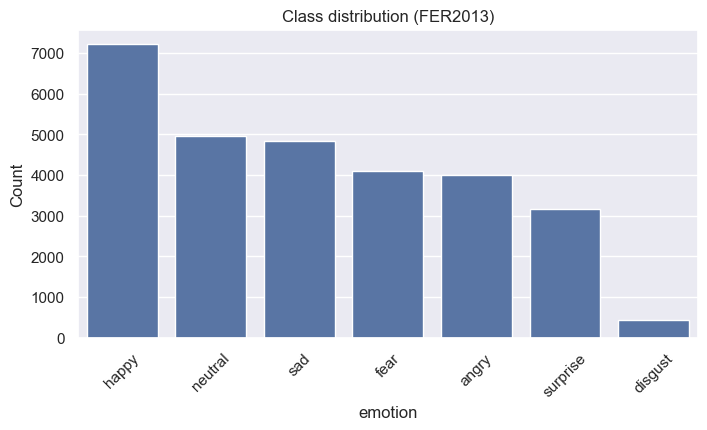

In [18]:
counts = df['emotion'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=45)
plt.title('Class distribution (FER2013)')
plt.ylabel('Count')
plt.show()


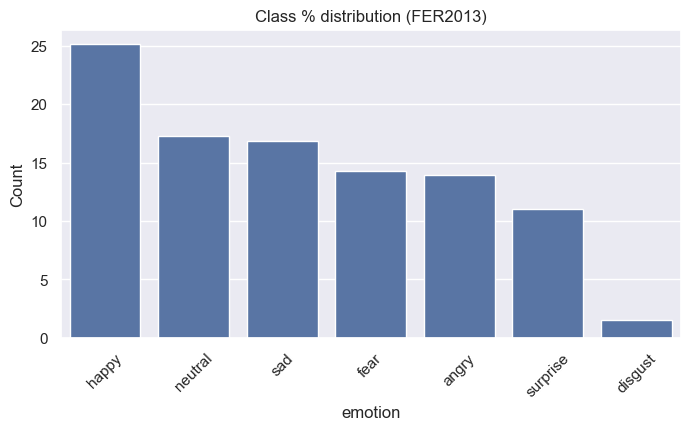

In [20]:
amt = df.shape[0]
counts = 100 * df['emotion'].value_counts() / amt
plt.figure(figsize=(8, 4))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=45)
plt.title(r'Class % distribution (FER2013)')
plt.ylabel('Count')
plt.show()


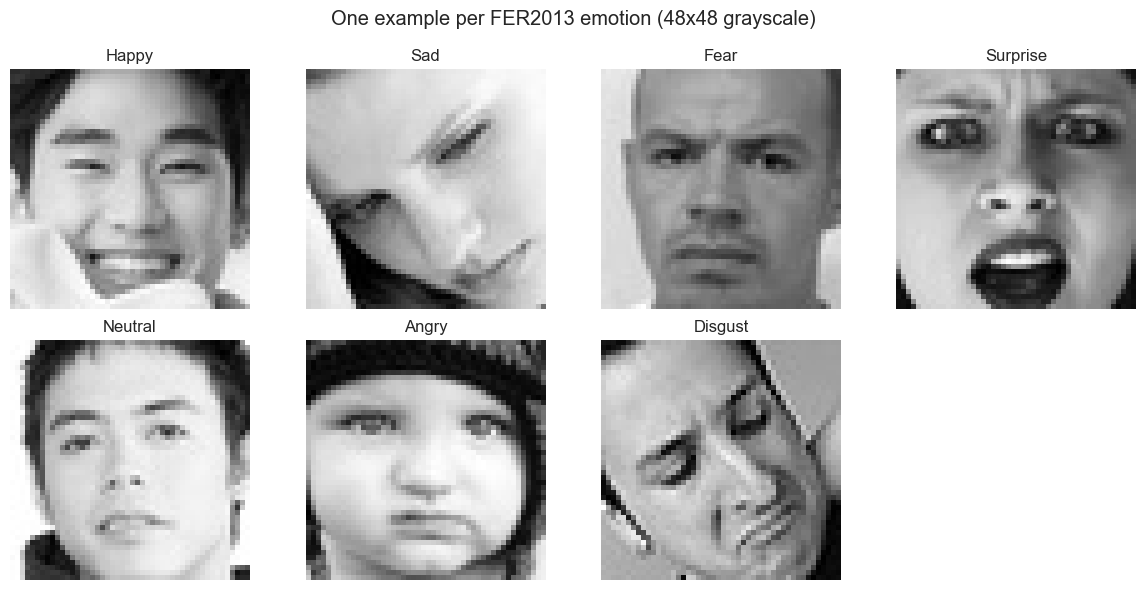

In [ ]:
def pixels_to_image(pix_str):
    arr = np.fromstring(pix_str, sep=' ', dtype=np.uint8)
    return arr.reshape((48, 48))

# Get one sample per emotion
sample = df.groupby('emotion', sort=False).sample(n=1, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 6))  # wider figure for 2x4 layout
for i, row in enumerate(sample.itertuples()):
    ax = plt.subplot(2, 4, i + 1)
    img = pixels_to_image(row.pixels)
    ax.imshow(img, cmap='gray')
    ax.set_title(row.emotion.capitalize())
    ax.axis('off')


plt.suptitle('One example per FER2013 emotion (48x48 grayscale)')
plt.tight_layout()
plt.show()


In [34]:
# Define a mapping string -> int
EMOTION_TO_ID = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}


In [40]:
n_val = int(0.1 * len(train_df))
train_df = train_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
val_df = train_df[:n_val].reset_index(drop=True)
train_df = train_df[n_val:].reset_index(drop=True)

print(r'Train / Val / Test sizes:', len(train_df), len(val_df), len(test_df))


Train / Val / Test sizes: 20931 2325 7178


In [ ]:
7178 / (20931 +2325 +7178)

0.3429363145573551


In [36]:
class FER2013Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pix = np.array(row['pixels'].split(), dtype=np.uint8)
        img = Image.fromarray(pix.reshape(48, 48))#no rgb conversion
        if self.transform:
            img = self.transform(img)
        label = EMOTION_TO_ID[row['emotion'].lower()]
        return img, label


imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pix = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8)
        img = Image.fromarray(pix.reshape(48, 48)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = EMOTION_TO_ID[row['emotion'].lower()]
        return img, label

# Datasets
train_ds = FER2013Dataset(train_df, transform=train_transform)
val_ds = FER2013Dataset(val_df, transform=val_transform)
test_ds = FER2013Dataset(test_df, transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [ ]:
try:
    from torchvision.models import resnet18, ResNet18_Weights
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
except Exception:
    model = torchvision.models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

# Freeze backbone layers
for name, param in model.named_parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

print(model)


In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, running_corrects, total = 0, 0, 0
    for inputs, labels in tqdm(dataloader, desc='Train', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()
        total += inputs.size(0)
    return running_loss / total, running_corrects / total


def eval_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0, 0, 0
    preds, labels_all = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Eval', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()
            total += inputs.size(0)
            preds.extend(outputs.argmax(1).cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return running_loss / total, running_corrects / total, np.array(preds), np.array(labels_all)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
num_epochs = 6

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs('models', exist_ok=True)
        torch.save(model.state_dict(), 'models/resnet18_head_only.pth')

print('Best validation accuracy:', best_val_acc)

# Optional full fine-tuning
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(1, 5):
    print(f'Fine-tune Epoch {epoch}/4')
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, device)
    print(f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'models/resnet18_finetuned.pth')


In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.legend()
plt.title('Accuracy')
plt.show()


In [ ]:
if os.path.exists(DATA_CSV):
    # Load best model
    path = None
    for p in ['models/resnet18_finetuned.pth', 'models/resnet18_head_only.pth']:
        if os.path.exists(p):
            path = p
            break
    if path:
        model.load_state_dict(torch.load(path, map_location=device))
        print(f'Loaded best model from {path}')

    test_loss, test_acc, preds, labels = eval_model(model, test_loader, criterion, device)
    print(f'Test Accuracy: {test_acc:.4f}')

    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(EMOTION_MAP.values()), yticklabels=list(EMOTION_MAP.values()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    print(classification_report(labels, preds, target_names=list(EMOTION_MAP.values()), digits=4))


In [ ]:
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/resnet18_final.pth')
print('Saved final model to models/resnet18_final.pth')


## Next Steps

- Add class weighting or oversampling to balance classes.
- Experiment with MobileNetV2 or EfficientNet.
- Apply face-cropping before feeding into the model.
- Create a live webcam demo for emotion recognition.
- Push results and trained models to GitHub Releases.
